# Inicializacion e imports

In [1]:
HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "512 Gaussian model"
EXPERIMENT_DESCRIPTION = "Inicializo con HCompV (sin args). \
                          Restimo (x3) con HERest ('-t', 250.0, 150.0, 1000.0). \
                          Guardo los archivos en cm-3. HCopy cn la opcion -Z (Cepstral mean substracted)\
                          Subo el numero de gaussianas hasta 512 [1,2,4,8,16,32,64,128,256,512]\
                          Agrego las transiciones del estado 2 al 4 y del 4 al 2 en el modelo de equilibrio"

%reload_ext autoreload

%autoreload 2

import src.visualization.visualize as viz
import src.HTK.htktools as htkt
import src.HTK.scripts as scripts

scripts.clean_interim()
scripts.clean_models()

# Inicializo Verta

In [2]:
from verta import Client

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: 512 Gaussian model
created new ExperimentRun: Run 782415949264412920265


# Logueo los archivos que voy a usar en el HTK

In [3]:
run.log_artifact("HTK_misc","../src/HTK/misc", overwrite=True)

scripts.display_artifact(which=['config.hcopy'])

upload complete (HTK_misc)
****   src/HTK/misc/config.hcopy   ****

 # Coding parameters
 SOURCEKIND = USER
 TARGETKIND = USER_D_A



# Preparo los datos

Convierto los datos crudos a formato HTK, separando 90% para entrenar y 10% para testear. Tambien creo los archivos necesarios para usar en HTK (train.scp, test.scp)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/home/gfogwil/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


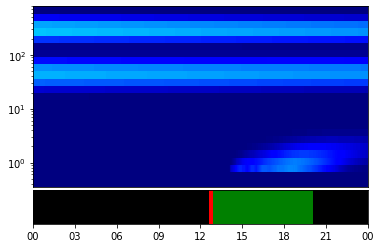

In [4]:
threshold = {'nuc_threshold': 0.7,       # 1/cm3/10min
             'con_threshold': 220,       # 1/m3^3/10min
             'coa_threshold': 2,         # 1/cm3/10min
             'dep_threshold': 2500}      # 1/m3^3/10min

viz.evaluate_hyperparameter_for_label('0.0-20150124.h5', threshold)

In [5]:
scripts.setup_data(convert_to_dndlogdp=False)

scripts.make_labels(threshold)

run.log_hyperparameters(threshold)

INFO:root:Converting raw files to HTK format ...
INFO:root:Files converted OK!
INFO:root:Creating labels ...
INFO:root:Labels created OK!


In [6]:
scripts.gen_scp_files()
scripts.gen_MLF()

INFO:root:Generating script (.scp) files...


Agrego las deltas y las aceleraciones tanto para test como para train:

In [7]:
# Test
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/test_hcopy.scp',
        '-T', 1])


run.log_observation('number_of_test_files', n)

# Train
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/train_hcopy.scp',
        '-T', 1])

run.log_observation('number_of_train_files', n)


### Inicializo el modelo de Markov

In [8]:
# Limpio todas todos los modelos y creo el modelo prototipo
scripts.clean_models()

In [9]:
most_trained_model = 0
htkt.HCompV(['-C', '../src/HTK/misc/config',
             '-S', '../data/interim/train.scp',
             '-M', '../models/hmm/' + str(most_trained_model),
             '-T', 1,
             '-f', 0.1,
             '-m',
             '../src/HTK/misc/proto'])

Calculating Fixed Variance
  HMM Prototype: ../src/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
222192 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory ../models/hmm/0
Var floor macros output to file ../models/hmm/0/vFloors



In [10]:
scripts.gen_hmmdefs()
scripts.gen_macros()

### Estimo los parametros

In [11]:
n = 3

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_1_gaussian', '../models/hmm/' + str(most_trained_model), overwrite=True)

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_1_gaussian)


### Evaluo

In [12]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(most_trained_model),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/3/macros -H ../models/hmm/3/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_3 ../src/HTK/misc/dict ../src/HTK/misc/monophones 



In [13]:
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(most_trained_model)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_1_gaussian', r['WORD_Corr'])

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:12:31 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_3
------------------------ Overall Results --------------------------
SENT: %Correct=1.05 [H=2, S=189, N=191]
WORD: %Corr=60.40, Acc=22.42 [H=299, D=166, S=30, I=188, N=495]



### Edito el modelo de equilibrio, le agrego dos trasiciones

In [14]:
htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/sil.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

### Edito el modelo, ahora uso 2 gaussianas

In [15]:
#most_trained_model = 3
print("Modelo inicial:", most_trained_model)
number_of_gaussians = 2

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

print("Modelo Final:", most_trained_model)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_2gaussians', r['WORD_Corr'])

Modelo inicial: 4

Pruning-Off

Pruning-Off

Pruning-Off

upload complete (model_2_gaussian)
Modelo Final: 8
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/8/macros -H ../models/hmm/8/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_2 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:18:17 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_2
------------------------ Overall Results --------------------------
SENT: %Correct=3.14 [H=6, S=185, N=191]
WORD: %Corr=59.80, Acc=9.70 [H=296, D=175, S=24, I=248, N=495]



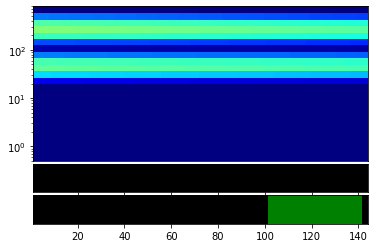

In [17]:
viz.evaluate_results(n_gaussians=2)

### Edito el modelo, ahora uso 4 gaussianas

In [18]:
#most_trained_model = 6
number_of_gaussians = 4

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
print("Modelo final:", most_trained_model)    
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_4_gaussians', r['WORD_Corr'])

Modelo inicial: 8

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 12
upload complete (model_4_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/12/macros -H ../models/hmm/12/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_4 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:18:37 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_4
------------------------ Overall Results --------------------------
SENT: %Correct=2.62 [H=5, S=186, N=191]
WORD: %Corr=60.20, Acc=-0.61 [H=298, D=170, S=27, I=301, N=495]



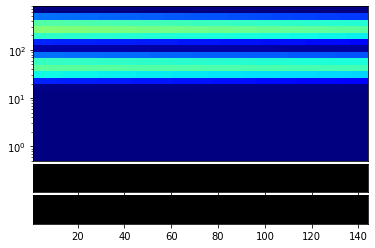

In [19]:
viz.evaluate_results(n_gaussians=4)

### Edito el modelo, ahora uso 8 gaussianas

In [20]:
#most_trained_model = 9
number_of_gaussians = 8

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            #'-p', 0,
            #'-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_8_gaussians', r['WORD_Corr'])

Modelo inicial: 12

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 15
upload complete (model_8_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/15/macros -H ../models/hmm/15/hmmdefs -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_8 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:18:50 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_8
------------------------ Overall Results --------------------------
SENT: %Correct=2.62 [H=5, S=186, N=191]
WORD: %Corr=61.21, Acc=1.82 [H=303, D=166, S=26, I=294, N=495]



### Edito el modelo, ahora uso 16 gaussianas

In [21]:
#most_trained_model = 12
number_of_gaussians = 16

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_16_aussians', r['WORD_Corr'])

Modelo inicial: 15

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 19
upload complete (model_16_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/19/macros -H ../models/hmm/19/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_16 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:19:07 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_16
------------------------ Overall Results --------------------------
SENT: %Correct=2.62 [H=5, S=186, N=191]
WORD: %Corr=62.22, Acc=-1.41 [H=308, D=164, S=23, I=315, N=495]



### Edito el modelo, ahora uso 32 gaussianas

In [22]:
#most_trained_model = 15
number_of_gaussians = 32

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_32_gaussians', r['WORD_Corr'])

Modelo inicial: 19

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 23
upload complete (model_32_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/23/macros -H ../models/hmm/23/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_32 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:19:35 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_32
------------------------ Overall Results --------------------------
SENT: %Correct=3.14 [H=6, S=185, N=191]
WORD: %Corr=63.84, Acc=2.83 [H=316, D=159, S=20, I=302, N=495]



### Edito el modelo, ahora uso 64 gaussianas

In [23]:
#most_trained_model = 18
number_of_gaussians = 64

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_64_gaussians', r['WORD_Corr'])

Modelo inicial: 23

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 27
upload complete (model_64_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_64 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:20:26 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_64
------------------------ Overall Results --------------------------
SENT: %Correct=2.09 [H=4, S=187, N=191]
WORD: %Corr=64.24, Acc=0.20 [H=318, D=155, S=22, I=317, N=495]



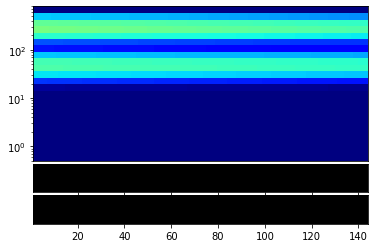

In [24]:
viz.evaluate_results(n_gaussians=64)

### Edito el modelo, ahora uso 128 gaussianas

In [25]:
most_trained_model = 21
number_of_gaussians = 128

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_128_gaussians', r['WORD_Corr'])

Modelo inicial: 21

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 24
upload complete (model_128_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_128 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:20:55 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_128
------------------------ Overall Results --------------------------
SENT: %Correct=3.14 [H=6, S=185, N=191]
WORD: %Corr=63.84, Acc=1.82 [H=316, D=156, S=23, I=307, N=495]



### Edito el modelo, ahora uso 256 gaussianas

In [26]:
most_trained_model = 24
number_of_gaussians = 256

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_256_gaussians', r['WORD_Corr'])

Modelo inicial: 24
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -M ../models/hmm/25 ../src/HTK/misc/pow256.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 27
upload complete (model_256_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_256 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:21:43 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_256
------------------------ Overall Results -------

### Edito el modelo, ahora uso 512 gaussianas

In [27]:
most_trained_model = 27
number_of_gaussians = 512

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_512_gaussians', r['WORD_Corr'])

Modelo inicial: 27
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -M ../models/hmm/28 ../src/HTK/misc/pow512.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 30
upload complete (model_512_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/30/macros -H ../models/hmm/30/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_512 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 16 16:23:06 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_512
------------------------ Overall Results -------

In [ ]:
viz.evaluate_results(n_gaussians=512)